# Angles
Nonlinear (DeepMDS)

mirrors the linear angular analysis, but uses a nonlinear DeepMDS embedding based on the paper pipeline (geodesic distances + DeepMDS).

## 0. Setup

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
import runpy # for running the model script 
import torch # for running the model and tensor operations

# Random number generator for reproducibility
rng = np.random.default_rng(0)

In [2]:
sys.path.append("../dim estimation")
from dimestimation_pipeline import estimate_intrinsic_dimension

## 1. Load FRGC dataset

In [3]:
FRGC_root = '/d1/jferna27/FRGC-nd1/all'
csv_path = '../frgc cluster/frgc_face_embeddings.csv'

if os.path.exists(csv_path): # CSV found, load from it
    print(f"Found {csv_path}, person ids loaded from csv")
    df = pd.read_csv(csv_path) #df.columns: 512d,image_file,, person_id
    image_files = df['image_file'].tolist()
    print(f"Total images: {len(image_files)}")
    person_ids = df['person_id'].tolist()  #person_id column from CSV
    unique_persons = sorted(list(set(person_ids)))
    print(f"Identities: {len(unique_persons)}")
    csv_pids = set(df['person_id'].tolist())

else: # CSV not found, use FRGC_root directory scan
    image_files = [f for f in os.listdir(FRGC_root) if f.endswith('.JPG') or f.endswith('.jpg')]
    print(f"Total images: {len(image_files)}")
    person_ids = [img[:5] for img in image_files] #person id (1st 5 characters)
    unique_persons = sorted(list(set(person_ids)))
    print(f"Identities: {len(unique_persons)}")
    

Found ../frgc cluster/frgc_face_embeddings.csv, person ids loaded from csv
Total images: 39327
Identities: 568


## 2. Initialize Face Detection + Embeddings + Exract embeddings

In [4]:
if os.path.exists(csv_path): #use csv if exists
    print("Found frgc_face_embeddings.csv")
    df = pd.read_csv(csv_path)
    drop_cols = ['image_file', 'person_id']
    emb_cols = [c for c in df.columns if c not in drop_cols]
    embeddings = df[emb_cols].values
    valid_person_ids = df['person_id'].tolist()  # Use person_id directly
    valid_image_files = df['image_file'].tolist()

else: #csv does not exist, process images to extract embeddings
    print(f"Processing with GPU 0 and 1")
    def process_batch_worker(gpu_id, batch_data):
        app = FaceAnalysis(name="buffalo_l")
        app.prepare(ctx_id=gpu_id, det_size=(160, 160))
        embs, pids, files = [], [], []
        for img_file, pid in tqdm(batch_data, desc=f"GPU {gpu_id}"):
            img = cv2.imread(os.path.join(FRGC_root, img_file))
            if img is not None:
                faces = app.get(img)
                if len(faces) > 0:
                    embs.append(faces[0].embedding)
                    pids.append(pid)
                    files.append(img_file)
        return {'embs': embs, 'pids': pids, 'files': files}
    
    person_ids_list = [img[:5] for img in image_files]
    mid = len(image_files) // 2
    results = Parallel(n_jobs=2, backend='loky')(
        delayed(process_batch_worker)(gpu_id, list(zip(image_files[start:end], person_ids_list[start:end])))
        for gpu_id, (start, end) in [(0, (0, mid)), (1, (mid, len(image_files)))]
    )
    embeddings = np.vstack([np.array(r['embs']) for r in results])
    valid_person_ids = sum([r['pids'] for r in results], [])
    valid_image_files = sum([r['files'] for r in results], [])

print(f"Embeddings: {embeddings.shape}")
print(f"Valid images: {len(valid_image_files)}")
print(f"Unique person_ids: {len(set(valid_person_ids))}")

Found frgc_face_embeddings.csv
Embeddings: (39327, 512)
Valid images: 39327
Unique person_ids: 568


In [5]:
if os.path.exists(csv_path):
    print(f"{csv_path} already exists.")
else: #save csv
    embeddings_df = pd.DataFrame(embeddings)
    embeddings_df['person_id'] = valid_person_ids
    embeddings_df['image_file'] = valid_image_files
    embeddings_df.to_csv('frgc_face_embeddings2.csv', index=False)
    print(f"Embeddings and person_ids saved to 'frgc_face_embeddings2.csv'")

../frgc cluster/frgc_face_embeddings.csv already exists.


## 2. Normalize Embeddings

To the instrinsic dimension is not necessary, bit to the angles calculations it is.

In [6]:
E = embeddings.astype(np.float32)
E = E / (np.linalg.norm(E, axis=1, keepdims=True) + 1e-12)

## 3. Cluster by identity

In [7]:
labels_arr = np.array(valid_person_ids) #array of person_ids
unique_ids = np.unique(labels_arr) #unique person ids
identity_indices = {pid: np.where(labels_arr == pid)[0] for pid in unique_ids} #map person_id to indices
identity_clusters = {pid: embeddings[idxs] for pid, idxs in identity_indices.items()} #map person_id to embeddings

## 4. Intrinsic Dimension Estimation 

In [8]:
#Global ID estimation using all embeddings
print("Global Intrinsic Dimension")

global_id, global_info = estimate_intrinsic_dimension(E, k=15)
print(f"Global estimated intrinsic dimension: {global_id:.2f}")

Global Intrinsic Dimension
Global estimated intrinsic dimension: 11.12


In [9]:
# Intrinsic Dimension per Identity
print("Intrinsic Dimension per Identity")

id_results = {}
for pid, cluster_emb in identity_clusters.items():
    n = int(cluster_emb.shape[0])

    m_id, info = estimate_intrinsic_dimension(cluster_emb, k=10)  # k mas bajo para clusters pequenos
    id_results[pid] = {
        "id": float(m_id) if m_id is not None else np.nan,
        "num_images": n,
        "r_max": info.get("r_max", np.nan),
        "sigma": info.get("sigma", np.nan)
    }

valid_items = [(pid, v) for pid, v in id_results.items() if np.isfinite(v["id"])]
valid_ids = [v["id"] for _, v in valid_items]
nan_count = sum(1 for v in id_results.values() if not np.isfinite(v["id"]))
sorted_ids = sorted(
    valid_items,
    key=lambda x: x[1]["id"]
)
print(f"\nAnalized identities: {len(id_results)}")
print(f"Valid IDs: {len(valid_ids)} | NaN IDs: {nan_count}")
if len(valid_ids) > 0:
    print(f"Average ID: {np.mean(valid_ids):.2f}")
    print(f"Std ID: {np.std(valid_ids):.2f}")
else:
    print("Average ID: n/a")
    print("Std ID: n/a")

Intrinsic Dimension per Identity

Analized identities: 568
Valid IDs: 565 | NaN IDs: 3
Average ID: 8.90
Std ID: 11.54


In [10]:
cluster_stats = {}
for pid, cluster in identity_clusters.items():
    centroid = cluster.mean(axis=0)
    distances = np.linalg.norm(cluster - centroid, axis=1)
    cluster_stats[pid] = {
        "centroid": centroid,
        "radius": float(distances.max()),
        "dispersion": float(distances.std()),
        "num_images": int(len(cluster))
    }

## 4. Run DeepMDS pipeline (trains model)

In [11]:
#executes deepmds_pipeline.py and returns its globals in a dict.
# The notebook lives in experiments/angles, so the script is in the same folder.
deepmds_path = os.path.join(os.getcwd(), "deepmds_pipeline.py")
if not os.path.exists(deepmds_path):
    raise FileNotFoundError(f"DeepMDS pipeline not found: {deepmds_path}")

# Pass both E (embeddings) and global_id (intrinsic dimension) to the pipeline
# The pipeline will use global_id to set embed_dim for the DeepMDS model
pipeline_globals = runpy.run_path(deepmds_path, init_globals={"E": E, "global_id": global_id})
model = pipeline_globals["model"] #get the model from the pipeline globals
device = pipeline_globals.get("device", torch.device("cpu")) #get device from pipeline globals, default to CPU if not defined

Training stage 1/6 with output dim 512
Reached stage 1, stopping forward at stage 0
Reached stage 1, stopping forward at stage 0
Reached stage 1, stopping forward at stage 0
Reached stage 1, stopping forward at stage 0
Reached stage 1, stopping forward at stage 0
Reached stage 1, stopping forward at stage 0
Reached stage 1, stopping forward at stage 0
Reached stage 1, stopping forward at stage 0
Reached stage 1, stopping forward at stage 0
Reached stage 1, stopping forward at stage 0
Reached stage 1, stopping forward at stage 0
Reached stage 1, stopping forward at stage 0
Reached stage 1, stopping forward at stage 0
Reached stage 1, stopping forward at stage 0
Reached stage 1, stopping forward at stage 0
Reached stage 1, stopping forward at stage 0
Reached stage 1, stopping forward at stage 0
Reached stage 1, stopping forward at stage 0
Reached stage 1, stopping forward at stage 0
Reached stage 1, stopping forward at stage 0
Reached stage 1, stopping forward at stage 0
Reached stage 1,

## 5. Get nonlinear embeddings


In [12]:
model.eval() # set model to evaluation mode
with torch.no_grad(): # disable gradient computation for inference
    x = torch.from_numpy(E.astype(np.float32)).to(device) #convert embeddings to torch tensor and move to device
    z = model(x)[-1].cpu().numpy() # get the last layer output, move to CPU and convert to numpy

z = z / (np.linalg.norm(z, axis=1, keepdims=True) + 1e-12) # normalize the nonlinear embeddings to unit length
print(f"Nonlinear embedding shape: {z.shape}") 

Nonlinear embedding shape: (39327, 12)


## 6. Angular distances in nonlinear space


It uses the nonlinear DeepMDS embeddings z, so the angles are computed in the nonlinear space even though the angle formula itself is linear.

in the future it could do something more manifold-aware, comparing geodesic distances (like the ones used by the pipeline during training).

In [13]:
cos_sim = np.clip(z @ z.T, -1.0, 1.0)
angles = np.arccos(cos_sim)
triu_idx = np.triu_indices_from(angles, k=1)
angular_distances = angles[triu_idx]
print(f"Computed {angular_distances.size} angular distances.")
print(f"Rad: Mean angle: {angular_distances.mean():.4f} rad, Std: {angular_distances.std():.4f} rad")
print(f"Deg: Mean angle: {np.degrees(angular_distances.mean()):.4f} deg, Std: {np.degrees(angular_distances.std()):.4f} deg")


Computed 773286801 angular distances.
Rad: Mean angle: 1.4080 rad, Std: 0.2996 rad
Deg: Mean angle: 80.6722 deg, Std: 17.1676 deg


## 7. Within vs across (nonlinear)


In [14]:
labels = np.array(valid_person_ids)
i_idx, j_idx = triu_idx
same_identity = labels[i_idx] == labels[j_idx] #boolean mask for pairs of embeddings that belong to the same identity
within_angles = angular_distances[same_identity] #same identity pairs
across_angles = angular_distances[~same_identity] #different identity pairs

print(f"Within-identity pairs: {within_angles.size}") 
print(f"  Mean angle: {within_angles.mean():.4f} rad, Std: {within_angles.std():.4f} rad")
print(f"  Mean angle: {np.degrees(within_angles.mean()):.4f} deg, Std: {np.degrees(within_angles.std()):.4f} deg")
print(f"Across-identity pairs: {across_angles.size}")
print(f"  Mean angle: {across_angles.mean():.4f} rad, Std: {across_angles.std():.4f} rad")
print(f"  Mean angle: {np.degrees(across_angles.mean()):.4f} deg, Std: {np.degrees(across_angles.std()):.4f} deg")


Within-identity pairs: 2163169
  Mean angle: 0.5688 rad, Std: 0.2401 rad
  Mean angle: 32.5889 deg, Std: 13.7551 deg
Across-identity pairs: 771123632
  Mean angle: 1.4104 rad, Std: 0.2965 rad
  Mean angle: 80.8075 deg, Std: 16.9859 deg


## 8. Histograms (density)


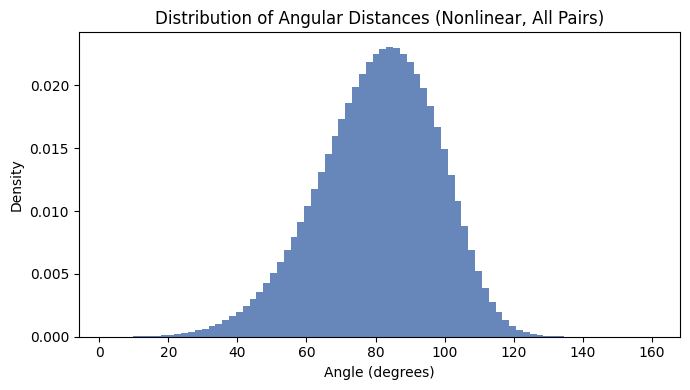

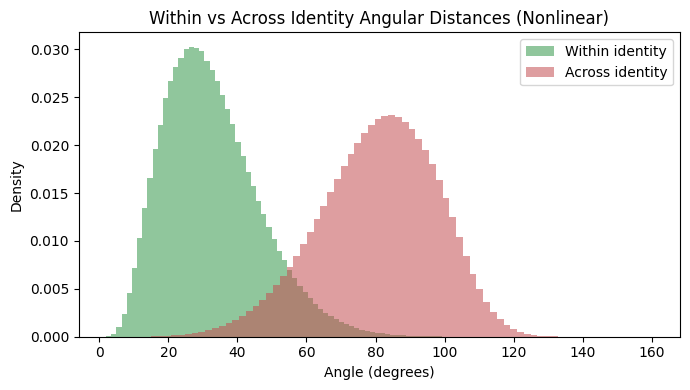

In [15]:
all_deg = np.degrees(angular_distances)
within_deg = np.degrees(within_angles)
across_deg = np.degrees(across_angles)
bins = 80

plt.figure(figsize=(7, 4))
plt.hist(all_deg, bins=bins, density=True, alpha=0.85, color="#4c72b0")
plt.title("Distribution of Angular Distances (Nonlinear, All Pairs)")
plt.xlabel("Angle (degrees)")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.hist(within_deg, bins=bins, density=True, alpha=0.65, label="Within identity", color="#55a868")
plt.hist(across_deg, bins=bins, density=True, alpha=0.55, label="Across identity", color="#c44e52")
plt.title("Within vs Across Identity Angular Distances (Nonlinear)")
plt.xlabel("Angle (degrees)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

## 9. Subspace angles in nonlinear space


In [16]:
def subspace_basis(X, k):
    Xc = X - X.mean(axis=0, keepdims=True)
    _, _, Vt = np.linalg.svd(Xc, full_matrices=False)
    return Vt[:k].T

def principal_angles(Q1, Q2):
    M = Q1.T @ Q2
    _, s, _ = np.linalg.svd(M, full_matrices=False)
    s = np.clip(s, -1.0, 1.0)
    return np.degrees(np.arccos(s))

In [17]:
labels_arr = np.array(valid_person_ids)
unique_ids = np.unique(labels_arr)
subspace_dim = 10
min_imgs = max(2 * subspace_dim, 6)
within_subspace_angles = []
subspace_per_id = {}

#within-identity subspace angles
for pid in unique_ids:
    idx = np.where(labels_arr == pid)[0]
    if idx.size < min_imgs:
        continue
    rng.shuffle(idx)
    half = idx.size // 2
    idx_a, idx_b = idx[:half], idx[half:]
    if idx_a.size < subspace_dim or idx_b.size < subspace_dim:
        continue

    #division of the embeddings of the same identity into two halves, computation of their subspace bases and principal angles between them
    Qa = subspace_basis(z[idx_a], subspace_dim)
    Qb = subspace_basis(z[idx_b], subspace_dim)
    within_subspace_angles.append(principal_angles(Qa, Qb))
    
    #calculates the subspace using all the embeddings of the same identity and stores it in a dict for later use in across-identity angle calculations
    Qfull = subspace_basis(z[idx], subspace_dim)
    subspace_per_id[pid] = Qfull

across_subspace_angles = []
ids = list(subspace_per_id.keys())
#across-identity subspace angles: compute principal angles between the subspaces of different identities using the precomputed subspace bases stored in the dict
for i in range(len(ids)):
    for j in range(i + 1, len(ids)):
        Qa = subspace_per_id[ids[i]]
        Qb = subspace_per_id[ids[j]]
        across_subspace_angles.append(principal_angles(Qa, Qb))

within_flat = np.concatenate(within_subspace_angles) if within_subspace_angles else np.array([])
across_flat = np.concatenate(across_subspace_angles) if across_subspace_angles else np.array([])

print(f"Within subspace angles: n={within_flat.size}, mean={within_flat.mean():.2f} deg")
print(f"Across subspace angles: n={across_flat.size}, mean={across_flat.mean():.2f} deg")

Within subspace angles: n=4470, mean=8.44 deg
Across subspace angles: n=996810, mean=13.51 deg


In [ ]:
plt.figure(figsize=(7, 4))
plt.hist(within_flat, bins=60, density=True, alpha=0.65, label="Within ID", color="#55a868")
plt.hist(across_flat, bins=60, density=True, alpha=0.55, label="Across ID", color="#c44e52")
plt.axvline(90, color="black", linestyle="--", linewidth=1, label="90 deg")
plt.title("Subspace Angle Comparison: Within vs Across (Nonlinear)")
plt.xlabel("Principal angle (degrees)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

## 10. Within angles per ID (nonlinear)

In [18]:
labels_arr = np.array(valid_person_ids)
unique_ids = np.unique(labels_arr)

per_id_stats = []
all_within_deg_nonlinear = []

for pid in unique_ids:
    idx = np.where(labels_arr == pid)[0]  # indices of embeddings for this person_id
    if idx.size < 2:
        continue

    zi = z[idx]  # nonlinear embeddings for this identity
    cos_i = np.clip(zi @ zi.T, -1.0, 1.0)  # cosine similarity matrix for this identity
    ang_i = np.arccos(cos_i)  # angular distance matrix for this identity
    triu_i = np.triu_indices_from(ang_i, k=1)  # upper triangle indices
    ang_i = ang_i[triu_i]  # angular distances for unique pairs within this identity

    ang_deg = np.degrees(ang_i)  # convert to degrees
    all_within_deg_nonlinear.append(ang_deg)

    # % of pairs within this identity that are near-orthogonal (85-95 deg)
    ortho_pct = np.mean((ang_deg >= 85.0) & (ang_deg <= 95.0)) * 100.0

    per_id_stats.append({
        "person_id": pid,
        "n_imgs": idx.size,
        "n_pairs": ang_deg.size,
        "mean_deg": float(np.mean(ang_deg)),
        "median_deg": float(np.median(ang_deg)),
        "std_deg": float(np.std(ang_deg)),
        "ortho_pct_85_95": float(ortho_pct),
    })

per_id_df = pd.DataFrame(per_id_stats).sort_values("mean_deg", ascending=False)
print("Top 10 identities (highest mean within-identity angles):")
print(per_id_df.head(10))
print("\nBottom 10 identities (lowest mean within-identity angles):")
print(per_id_df.tail(10))

Top 10 identities (highest mean within-identity angles):
     person_id  n_imgs  n_pairs   mean_deg  median_deg    std_deg  \
558       4925      24      276  62.807156   62.907852  22.044907   
206       4538       6       15  61.644829   68.164665  24.021997   
385       4750      42      861  60.706532   60.747467  18.557940   
452       4818      42      861  58.538975   58.722370  20.837719   
200       4529      44      946  58.264778   59.528511  18.352222   
125       4422      96     4560  58.119011   55.763805  19.687208   
513       4879       6       15  58.057774   56.820087  21.810287   
272       4621      12       66  57.380402   56.876556  21.073580   
215       4551      64     2016  57.217346   55.644455  17.339268   
390       4755      12       66  56.703072   58.566891  22.733269   

     ortho_pct_85_95  
558         9.420290  
206         6.666667  
385         8.013937  
452         8.246225  
200         5.602537  
125         5.175439  
513         0.000000  

**Metrics interpretation:**
- `mean_deg` < 48°: compact identity (mean cos_sim ≈ 0.67)
- `mean_deg` < 30°: very compact identity (mean cos_sim ≈ 0.87)
- `ortho_pct_85_95`: % of near-orthogonal pairs (noise indicator)

**Global distribution of within-identity angles (nonlinear space)**

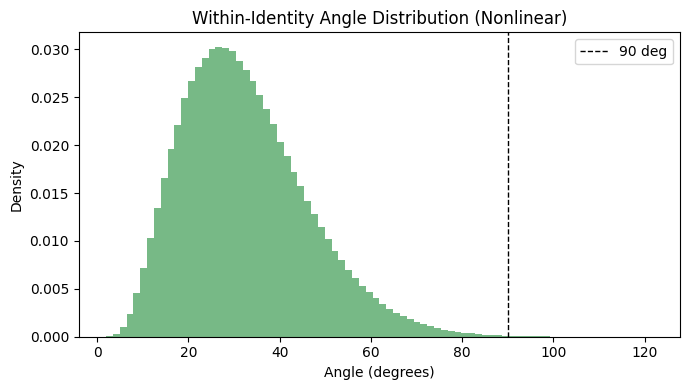

Within-identity near-orthogonal (85-95 deg): 0.11%


In [19]:
all_within_deg_nonlinear = np.concatenate(all_within_deg_nonlinear)
plt.figure(figsize=(7, 4))
plt.hist(all_within_deg_nonlinear, bins=80, density=True, alpha=0.8, color="#55a868")
plt.axvline(90, color="black", linestyle="--", linewidth=1, label="90 deg")
plt.title("Within-Identity Angle Distribution (Nonlinear)")
plt.xlabel("Angle (degrees)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

ortho_global_nonlinear = np.mean((all_within_deg_nonlinear >= 85.0) & (all_within_deg_nonlinear <= 95.0)) * 100.0
print(f"Within-identity near-orthogonal (85-95 deg): {ortho_global_nonlinear:.2f}%")